### Preprocessing

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch

from dataset import Dataset

start_date = '2021-01-01'
end_date = '2021-12-31'
ticker = ['AAPL']

EMAs = [8,10,20,50,75,100]
SMAs = [8,10,20,50,75,100]

df = Dataset.get_qry(ticker,start_date,end_date)

data_processed = Dataset.process(df,EMA_list=EMAs,SMA_list=SMAs)
data = data_processed[0]
# trading_data = data_processed[1] - Not Needed as No profit on non trading days = Not in Dataset


data.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test = data.dropna().copy()

# Min Max Scaling
min_max_scaler = MinMaxScaler()
columns_to_scale = data.columns.drop(['Profit'])
data[columns_to_scale] = min_max_scaler.fit_transform(data[columns_to_scale])

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna().copy()
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 101867 entries, 253 to 206143
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Profit      101867 non-null  float64
 1   EMA8_pct    101867 non-null  float64
 2   EMA10_pct   101867 non-null  float64
 3   EMA20_pct   101867 non-null  float64
 4   EMA50_pct   101867 non-null  float64
 5   EMA75_pct   101867 non-null  float64
 6   EMA100_pct  101867 non-null  float64
 7   SMA8_pct    101867 non-null  float64
 8   SMA10_pct   101867 non-null  float64
 9   SMA20_pct   101867 non-null  float64
 10  SMA50_pct   101867 non-null  float64
 11  SMA75_pct   101867 non-null  float64
 12  SMA100_pct  101867 non-null  float64
 13  dydx        101867 non-null  float64
 14  dydx2       101867 non-null  float64
dtypes: float64(15)
memory usage: 12.4 MB
None


### Training Model

In [2]:
from CNN import Generate

param_grid = {
    'lr': [1e-3],  # Learning rates to test
    'batch_size': [128],  # Batch sizes to test
    'conv1_out_channels': [16],  # Number of filters in the first conv layer
    'conv2_out_channels': [16],  # Number of filters in the second conv layer
    'epcoch':[30]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Train_split = 0.75

model = Generate.Model(data,device=device,Train_split=Train_split,param_grid=param_grid)


cuda
Testing combination: lr=0.001, batch_size=128, conv1_out_channels=16, conv2_out_channels=16, epcoch=30


c:\Design Folder\RBGithub\Financial-Forecasting\CNNs\CNN.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  packets_tensor = torch.tensor(Packets).float()


KeyboardInterrupt: 

### Testing CNN Model

Average Test Loss: 0.0001


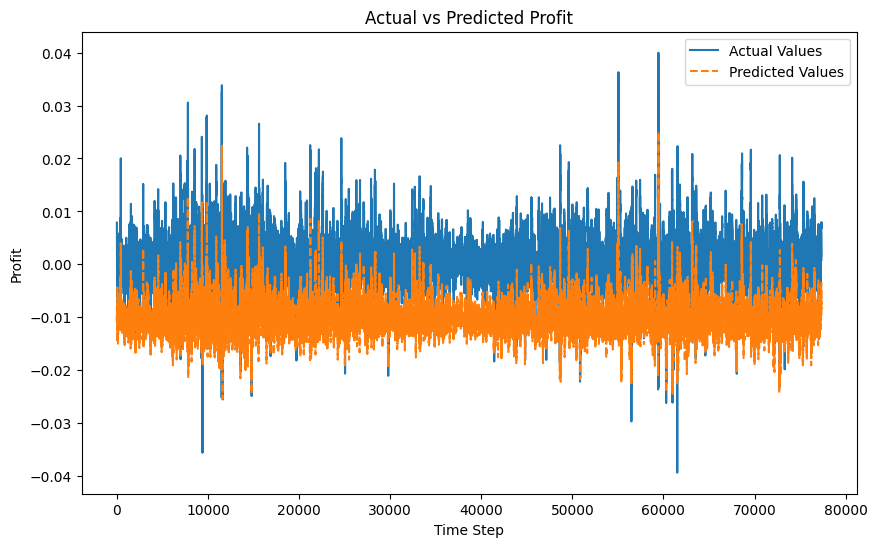

In [3]:
from torch.utils.data import DataLoader, random_split, TensorDataset

# Assuming df_test contains your test data

start_date = '2022-04-01'
end_date = '2022-4-31'
ticker = ['AAPL']

EMAs = [8,10,20,50,75,100]
SMAs = [8,10,20,50,75,100]

df = Dataset.get_qry(ticker,start_date,end_date)

data_processed = Dataset.process(df,EMA_list=EMAs,SMA_list=SMAs)
data = data_processed[0]
# trading_data = data_processed[1] - Not Needed as No profit on non trading days = Not in Dataset

data.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test = data.dropna().copy()

# Min Max Scaling
min_max_scaler = MinMaxScaler()
columns_to_scale = data.columns.drop(['Profit'])
data[columns_to_scale] = min_max_scaler.fit_transform(data[columns_to_scale])

data.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test = data.dropna().copy()

test_packets = []
packet_size = 20  # Same as used in training

for i in range(packet_size, len(df_test)+1):
    snapshot = df_test.iloc[i-3:i].values  # Adjust depending on how you prepared the training data
    test_packets.append(snapshot)

test_packets_tensor = torch.tensor(test_packets).float()
test_packets_tensor = test_packets_tensor.unsqueeze(1)  # Reshape to add a channel dimension

test_target_tensor = torch.tensor(df_test['Profit'].values).float()
test_target_tensor = test_target_tensor[:test_packets_tensor.shape[0]]

# Create the test TensorDataset
test_dataset = TensorDataset(test_packets_tensor, test_target_tensor)
test_loader = DataLoader(test_dataset, batch_size=128)  # Adjust batch size if needed

model.eval()  # Set model to evaluation mode
test_loss = 0  # Track the total test loss
test_predictions = []

# Set loss function (same as used during training)
lossFn = torch.nn.MSELoss()

# No need to calculate gradients during evaluation
with torch.no_grad():
    for (x, y) in test_loader:
        x, y = x.to(device), y.to(device)  # Move data to the same device as the model
        pred = model(x)  # Get predictions from the model
        loss = lossFn(pred.squeeze(), y)  # Calculate loss
        test_loss += loss.item()  # Accumulate test loss
        
        test_predictions.append(pred.cpu().numpy())  # Optionally collect predictions for analysis

# Calculate the average test loss
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

import matplotlib.pyplot as plt
import numpy as np

# Convert predictions to a single numpy array
test_predictions = np.concatenate(test_predictions).flatten()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_test['Profit'].values[:len(test_predictions)], label='Actual Values')
plt.plot(test_predictions, label='Predicted Values', linestyle='--')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Profit')
plt.title('Actual vs Predicted Profit')
plt.show()




### Compare to Gradient Boost Model

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

from dataset import Dataset

start_date = '2013-01-01'
end_date = '2021-12-31'
ticker = ['AAPL']

EMAs = [8,20,100]
SMAs = [8,100]

df = Dataset.get_qry(ticker,start_date,end_date)

p_data = Dataset.packeting(df,50, EMAs, SMAs)

p_data.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test = p_data.dropna().copy()

# Min Max Scaling
min_max_scaler = MinMaxScaler()
columns_to_scale = p_data.columns.drop(['Profit'])
p_data[columns_to_scale] = min_max_scaler.fit_transform(p_data[columns_to_scale])

p_data.replace([np.inf, -np.inf], np.nan, inplace=True)
p_data = p_data.dropna().copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533985 entries, 0 to 1533984
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Datetime  1533985 non-null  datetime64[us]
 1   open      1533985 non-null  float32       
 2   high      1533985 non-null  float32       
 3   low       1533985 non-null  float32       
 4   close     1533985 non-null  float32       
 5   volume    1533985 non-null  float32       
 6   Stock     1533985 non-null  object        
 7   interval  1533985 non-null  float32       
dtypes: datetime64[us](1), float32(6), object(1)
memory usage: 58.5+ MB
None


<class 'numpy.ndarray'>
109796
Profit
<class 'float'>    137246
Name: count, dtype: int64
RMSE: 0.004131905421359702
Best parameters found: {'learning_rate': 0.1, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 1.0}
<class 'dict'>


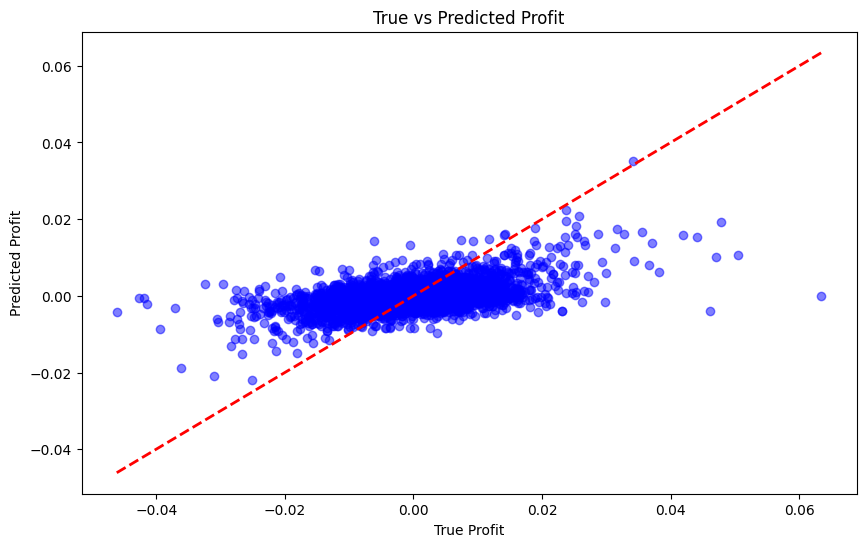

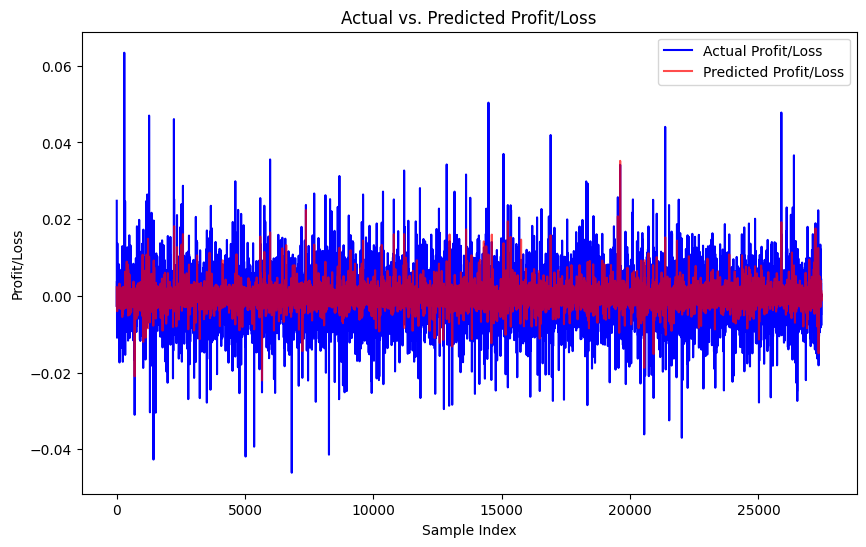

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor()


param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [10],
    'subsample': [1.0],
    'max_features': ['sqrt']
}

'''
Attempt 1 - best from grid search
Data - APPL '2021-06-01' '2021-12-31'
RSME - 0.001282
Best parameters found: {'learning_rate': 0.1, 
                        'max_depth': 20, 
                        'max_features': 'sqrt', 
                        'min_samples_leaf': 10, 
                        'min_samples_split': 5, 
                        'n_estimators': 300, 
                        'subsample': 1.0}

Attempt 2 - 
Data - APPL '2021-01-01' '2021-12-31'
RMSE: 0.002431


'''

# Convert lists in the 'Profit' column to their mean
p_data['Profit'] = p_data['Profit'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
p_data = p_data[p_data['Profit']<5]
X = p_data.drop(columns=['Profit'])
y = p_data[['Profit']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel()

print(type(y_train))
print(len(y_train))
print(p_data['Profit'].apply(type).value_counts())  # Check for types in the 'Profit' column


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
predictions = grid_search.predict(X_test)  # Predict on the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")


print(f"Best parameters found: {grid_search.best_params_}")
print(type(grid_search.best_params_))

# Plotting the results
plt.figure(figsize=(10, 6))

# Scatter plot of true vs predicted values
plt.scatter(y_test, predictions, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Add labels and title
plt.xlabel('True Profit')
plt.ylabel('Predicted Profit')
plt.title('True vs Predicted Profit')

# Show plot
plt.show()



plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Profit/Loss', color='blue')
plt.plot(predictions, label='Predicted Profit/Loss', color='red', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Profit/Loss')
plt.title('Actual vs. Predicted Profit/Loss')
plt.legend()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425464 entries, 0 to 425463
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  425464 non-null  datetime64[us]
 1   open      425464 non-null  float32       
 2   high      425464 non-null  float32       
 3   low       425464 non-null  float32       
 4   close     425464 non-null  float32       
 5   volume    425464 non-null  float32       
 6   Stock     425464 non-null  object        
 7   interval  425464 non-null  float32       
dtypes: datetime64[us](1), float32(6), object(1)
memory usage: 16.2+ MB
None
RMSE: 0.007500786457078159


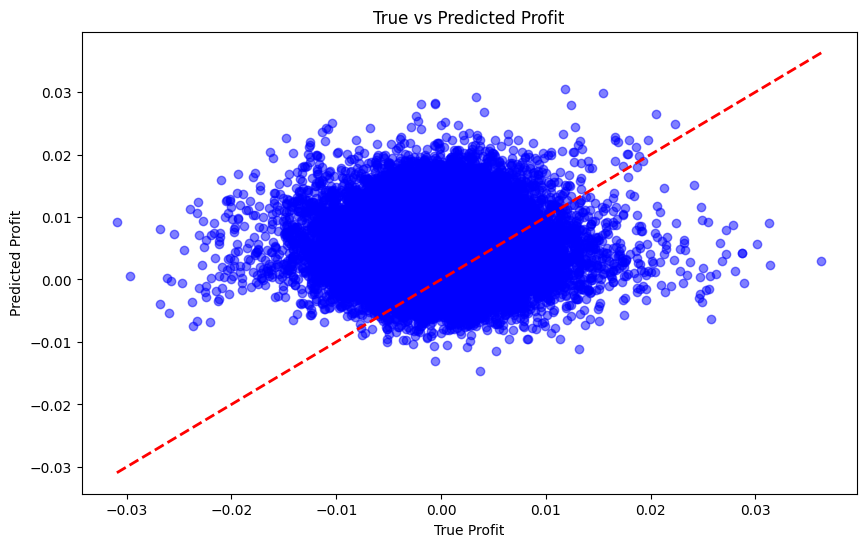

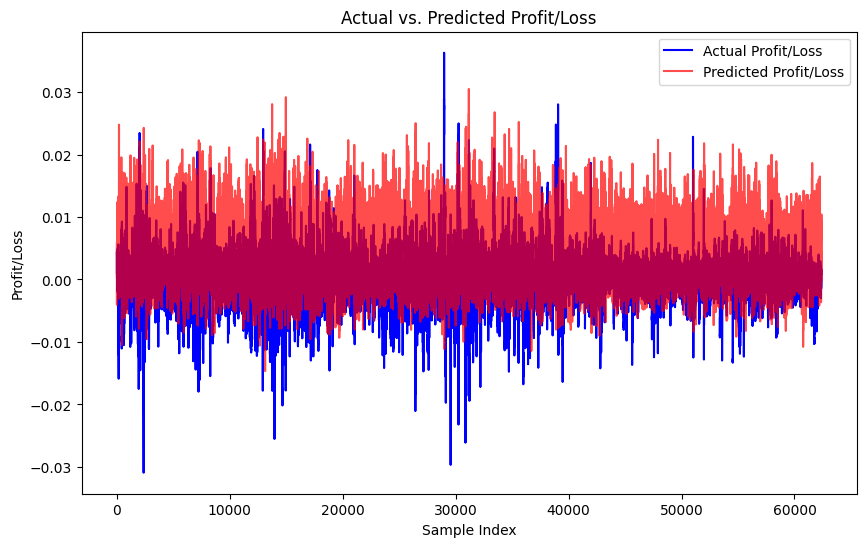

In [3]:
# Use the model to predict the next year

start_date = '2022-01-01'
end_date = '2023-12-31'
ticker = ['AAPL']

EMAs = [8,20,100]
SMAs = [8,100]

df = Dataset.get_qry(ticker,start_date,end_date)

p_data = Dataset.packeting(df,50, EMAs, SMAs)

p_data.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test = p_data.dropna().copy()

# Min Max Scaling
min_max_scaler = MinMaxScaler()
columns_to_scale = p_data.columns.drop(['Profit'])
p_data[columns_to_scale] = min_max_scaler.fit_transform(p_data[columns_to_scale])

p_data.replace([np.inf, -np.inf], np.nan, inplace=True)
p_data = p_data.dropna().copy()


p_data['Profit'] = p_data['Profit'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
p_data = p_data[p_data['Profit']<5]
X = p_data.drop(columns=['Profit'])
y = p_data[['Profit']]
predictions = grid_search.predict(X)  # Predict on the test set

rmse = np.sqrt(mean_squared_error(y, predictions))
print(f"RMSE: {rmse}")

# Plotting the results
plt.figure(figsize=(10, 6))

# Scatter plot of true vs predicted values
plt.scatter(y, predictions, color='blue', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)

# Add labels and title
plt.xlabel('True Profit')
plt.ylabel('Predicted Profit')
plt.title('True vs Predicted Profit')

# Show plot
plt.show()



plt.figure(figsize=(10, 6))
plt.plot(y.values, label='Actual Profit/Loss', color='blue')
plt.plot(predictions, label='Predicted Profit/Loss', color='red', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Profit/Loss')
plt.title('Actual vs. Predicted Profit/Loss')
plt.legend()
plt.show()

